# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples

In [1]:
TGT='Reply'
PRFX='Reply0405_4'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(1e5)#int(1e5)
trnsz = int(1e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.set_verbosity(optuna.logging.ERROR)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(100000, 24)


retwt          0.11211
reply          0.02754
like           0.43929
retwt_cmmnt    0.00801
dtype: float64

CPU times: user 742 ms, sys: 84.2 ms, total: 826 ms
Wall time: 824 ms


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(370000, 24)


retwt          0.112570
reply          0.028143
like           0.438841
retwt_cmmnt    0.007565
dtype: float64

CPU times: user 2.78 s, sys: 336 ms, total: 3.11 s
Wall time: 3.11 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(100000, 24) 0.10413
370000 10413 100000 10413


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
5,101\t1434\t107854\t18260\t31904\t111431\t74759...,NaN,0EB15633A8CC0A6E3917C272F43E6DF3,NaN,NaN,NaN,TopLevel,022EC308651FACB02794A8147AEE1B78,1581218899,A7E00C86B4E3709D589754A51042A360,1198215,662,True,1246548812,016212C070A76EAB37E8ED93CA509BA9,0,42,False,1578271262,False,False,True,False,False
51,101\t10473\t10116\t10132\t12603\t97953\t25307\...,NaN,7C71C144E7B9F2D87F1F4DDB40AB1C49,NaN,NaN,NaN,TopLevel,2996EB2FE8162C076D070A4C8D6532CD,1581203618,B0CBECD53C3B945C875C55DDFF56D13F,1424,854,False,1394906655,01625341E5A48963E5AA7DFFDC4436D4,643,327,False,1372760933,True,False,True,False,False
63,101\t56898\t137\t24362\t131\t100\t196\t36351\t...,NaN,ADCF033A7C7087C1506E2BC3E2D8F092,NaN,NaN,NaN,Retweet,717293301FE296B0B61950D041485825,1581258397,ECD90FC37F0A7C15C82834FDDEEDC21A,1753,811,False,1568347799,01625CCEC5A4C322FC247DB9E223CC08,147,1355,False,1355850070,False,False,True,False,False
75,101\t12441\t105702\t793\t61783\t34022\t60578\t...,NaN,7EB0824DDA3D28844CC0FF65B7C4AA08,NaN,NaN,NaN,TopLevel,167115458A0DBDFF7E9C0C53A83BAC9B,1581271814,D905F31F909CC63C2BBEB7F6B43487FE,175998,116,False,1466830888,01626B64A2570C2807AB97716262FBA9,90,139,False,1364278366,False,False,True,False,False
83,101\t69532\t10107\t12372\t10160\t19048\t136\t1...,NaN,0A95516F028EBFF6B551DB32C4B2D1B5,Video,NaN,NaN,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581214010,88E80BAB56E6F59E4EF012A8B12D3BAE,8825,8024,False,1557262802,0162759D8908AA8C849F06086A023D85,26265,24215,False,1557422269,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    
    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-06 02:36:54 start
2020-04-06 02:36:56 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 02:36:58 freq of tags
2020-04-06 02:36:59 done
CPU times: user 4.52 s, sys: 253 ms, total: 4.77 s
Wall time: 4.68 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-06 02:36:59 start
2020-04-06 02:37:00 freq of columns using CountEncoder
2020-04-06 02:37:02 freq of tags
2020-04-06 02:37:03 done
CPU times: user 3.98 s, sys: 56.7 ms, total: 4.04 s
Wall time: 4.02 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'len_toks',
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 'has_hshtgs',
       'n_hshtgs', 'has_media', 'n_media', 'has_domns', 'n_domns', 'dayofweek',
       'hour', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twt_age',
       'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age', 'u1_fllwng_cnt_by_age',
       'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp', 'frq_lang', 'frq_u1id',
       'frq_u1_fllwing_cnt', 'frq_u1_vrfed', 'frq_u2id', 'frq_u2_fllwer_cnt',
       'frq_u2_vrfed', 'frq_u1_fllw_u2', 'frq_n_media_Photo',
       'frq_n_media_Video', 'frq_n_media_GIF', 'frq_has_hshtgs',
       'frq_n_hshtgs', 'frq_has_media', 'frq_n_media', 'frq_has_domns',
       'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2', 'frq_langhour',
       'sumfrq_hshtgs', 'maxfrq_hshtgs', 'su

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 4.77 s, sys: 0 ns, total: 4.77 s
Wall time: 4.76 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

In [16]:
dftr.dtypes

twttyp                   category
lang                     category
u1_fllwer_cnt               int64
u1_fllwing_cnt              int64
u1_vrfed                     bool
u2_fllwer_cnt               int64
u2_fllwng_cnt               int64
u2_vrfed                     bool
u1_fllw_u2                   bool
retwt                        bool
reply                        bool
like                         bool
retwt_cmmnt                  bool
len_toks                    int64
n_media_Photo               int64
n_media_Video               int64
n_media_GIF                 int64
has_hshtgs                   bool
n_hshtgs                    int64
has_media                    bool
n_media                     int64
has_domns                    bool
n_domns                     int64
dayofweek                   int64
hour                        int64
tmdlta_u2u1                 int64
tmdlta_twtu1                int64
tmdlta_twtu2                int64
twt_age                     int64
u1_age        

# model

In [17]:
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
 'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
 'frq_dayofweek',
 'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]

In [18]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [19]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,
    
}
results['params'] = params

In [20]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254041	vl's binary_logloss: 0.287873
Early stopping, best iteration is:
[68]	tr's binary_logloss: 0.262654	vl's binary_logloss: 0.28726


tune_feature_fraction, val_score: 0.287260:  14%|#4        | 1/7 [00:01<00:09,  1.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251619	vl's binary_logloss: 0.287766
[200]	tr's binary_logloss: 0.229361	vl's binary_logloss: 0.288833
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.247205	vl's binary_logloss: 0.287478


tune_feature_fraction, val_score: 0.287260:  29%|##8       | 2/7 [00:03<00:08,  1.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249783	vl's binary_logloss: 0.289138
Early stopping, best iteration is:
[52]	tr's binary_logloss: 0.264249	vl's binary_logloss: 0.288221


tune_feature_fraction, val_score: 0.287260:  43%|####2     | 3/7 [00:04<00:06,  1.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248078	vl's binary_logloss: 0.288333
[200]	tr's binary_logloss: 0.225543	vl's binary_logloss: 0.289654
Early stopping, best iteration is:
[112]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.288161


tune_feature_fraction, val_score: 0.287260:  57%|#####7    | 4/7 [00:06<00:04,  1.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246437	vl's binary_logloss: 0.288998
Early stopping, best iteration is:
[53]	tr's binary_logloss: 0.261323	vl's binary_logloss: 0.288571


tune_feature_fraction, val_score: 0.287260:  71%|#######1  | 5/7 [00:07<00:02,  1.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246143	vl's binary_logloss: 0.288705
Early stopping, best iteration is:
[42]	tr's binary_logloss: 0.26621	vl's binary_logloss: 0.288272


tune_feature_fraction, val_score: 0.287260:  86%|########5 | 6/7 [00:08<00:01,  1.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245335	vl's binary_logloss: 0.289696
Early stopping, best iteration is:
[59]	tr's binary_logloss: 0.258213	vl's binary_logloss: 0.288818


tune_num_leaves, val_score: 0.287260:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.200864	vl's binary_logloss: 0.290524
Early stopping, best iteration is:
[61]	tr's binary_logloss: 0.226123	vl's binary_logloss: 0.288796


tune_num_leaves, val_score: 0.287260:   5%|5         | 1/20 [00:02<00:42,  2.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.161908	vl's binary_logloss: 0.292596
Early stopping, best iteration is:
[34]	tr's binary_logloss: 0.229395	vl's binary_logloss: 0.289451


tune_num_leaves, val_score: 0.287260:  10%|#         | 2/20 [00:05<00:44,  2.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.193083	vl's binary_logloss: 0.289818
Early stopping, best iteration is:
[68]	tr's binary_logloss: 0.214549	vl's binary_logloss: 0.288457


tune_num_leaves, val_score: 0.287260:  15%|#5        | 3/20 [00:07<00:42,  2.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.154114	vl's binary_logloss: 0.292918
Early stopping, best iteration is:
[34]	tr's binary_logloss: 0.224461	vl's binary_logloss: 0.289607


tune_num_leaves, val_score: 0.287260:  20%|##        | 4/20 [00:10<00:42,  2.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.283525	vl's binary_logloss: 0.288355
[200]	tr's binary_logloss: 0.278093	vl's binary_logloss: 0.287222
[300]	tr's binary_logloss: 0.274163	vl's binary_logloss: 0.286753
[400]	tr's binary_logloss: 0.270595	vl's binary_logloss: 0.286304
[500]	tr's binary_logloss: 0.267787	vl's binary_logloss: 0.286368
Early stopping, best iteration is:
[459]	tr's binary_logloss: 0.268991	vl's binary_logloss: 0.286251


tune_num_leaves, val_score: 0.286251:  25%|##5       | 5/20 [00:12<00:37,  2.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.14977	vl's binary_logloss: 0.295038
Early stopping, best iteration is:
[36]	tr's binary_logloss: 0.217996	vl's binary_logloss: 0.291528


tune_num_leaves, val_score: 0.286251:  30%|###       | 6/20 [00:16<00:37,  2.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.14679	vl's binary_logloss: 0.294724
Early stopping, best iteration is:
[36]	tr's binary_logloss: 0.216395	vl's binary_logloss: 0.290264


tune_num_leaves, val_score: 0.286251:  35%|###5      | 7/20 [00:19<00:37,  2.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.209287	vl's binary_logloss: 0.290342
Early stopping, best iteration is:
[56]	tr's binary_logloss: 0.235865	vl's binary_logloss: 0.288664


tune_num_leaves, val_score: 0.286251:  40%|####      | 8/20 [00:21<00:31,  2.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.148386	vl's binary_logloss: 0.29378
Early stopping, best iteration is:
[36]	tr's binary_logloss: 0.218013	vl's binary_logloss: 0.290511


tune_num_leaves, val_score: 0.286251:  45%|####5     | 9/20 [00:24<00:30,  2.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.160569	vl's binary_logloss: 0.294366
Early stopping, best iteration is:
[34]	tr's binary_logloss: 0.227816	vl's binary_logloss: 0.291275


tune_num_leaves, val_score: 0.286251:  50%|#####     | 10/20 [00:27<00:28,  2.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.296087	vl's binary_logloss: 0.294695
[200]	tr's binary_logloss: 0.291854	vl's binary_logloss: 0.291869
[300]	tr's binary_logloss: 0.290132	vl's binary_logloss: 0.29094
[400]	tr's binary_logloss: 0.289165	vl's binary_logloss: 0.290406
[500]	tr's binary_logloss: 0.288543	vl's binary_logloss: 0.290236
[600]	tr's binary_logloss: 0.28812	vl's binary_logloss: 0.2901
[700]	tr's binary_logloss: 0.287812	vl's binary_logloss: 0.29003
[800]	tr's binary_logloss: 0.28757	vl's binary_logloss: 0.289997
[900]	tr's binary_logloss: 0.287376	vl's binary_logloss: 0.289988
Early stopping, best iteration is:
[859]	tr's binary_logloss: 0.287453	vl's binary_logloss: 0.289953


tune_num_leaves, val_score: 0.286251:  55%|#####5    | 11/20 [00:30<00:25,  2.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.240094	vl's binary_logloss: 0.287867
Early stopping, best iteration is:
[61]	tr's binary_logloss: 0.254584	vl's binary_logloss: 0.287071


tune_num_leaves, val_score: 0.286251:  60%|######    | 12/20 [00:31<00:19,  2.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275689	vl's binary_logloss: 0.28734
Early stopping, best iteration is:
[96]	tr's binary_logloss: 0.276158	vl's binary_logloss: 0.287286


tune_num_leaves, val_score: 0.286251:  65%|######5   | 13/20 [00:32<00:13,  1.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242115	vl's binary_logloss: 0.288037
Early stopping, best iteration is:
[71]	tr's binary_logloss: 0.252321	vl's binary_logloss: 0.287297


tune_num_leaves, val_score: 0.286251:  70%|#######   | 14/20 [00:34<00:10,  1.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.239087	vl's binary_logloss: 0.287424
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.245226	vl's binary_logloss: 0.287054


tune_num_leaves, val_score: 0.286251:  75%|#######5  | 15/20 [00:35<00:08,  1.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.23786	vl's binary_logloss: 0.288473
Early stopping, best iteration is:
[61]	tr's binary_logloss: 0.253332	vl's binary_logloss: 0.287854


tune_num_leaves, val_score: 0.286251:  80%|########  | 16/20 [00:37<00:06,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.219449	vl's binary_logloss: 0.288669
Early stopping, best iteration is:
[73]	tr's binary_logloss: 0.233317	vl's binary_logloss: 0.288226


tune_num_leaves, val_score: 0.286251:  85%|########5 | 17/20 [00:39<00:05,  1.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.183959	vl's binary_logloss: 0.290998
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.217992	vl's binary_logloss: 0.288631


tune_num_leaves, val_score: 0.286251:  90%|######### | 18/20 [00:42<00:04,  2.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26429	vl's binary_logloss: 0.287108
Early stopping, best iteration is:
[78]	tr's binary_logloss: 0.268475	vl's binary_logloss: 0.286977


tune_num_leaves, val_score: 0.286251:  95%|#########5| 19/20 [00:43<00:01,  1.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261894	vl's binary_logloss: 0.287121
Early stopping, best iteration is:
[76]	tr's binary_logloss: 0.267003	vl's binary_logloss: 0.286911


tune_num_leaves, val_score: 0.286251: 100%|##########| 20/20 [00:44<00:00,  2.21s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.286251:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.285771	vl's binary_logloss: 0.288988
[200]	tr's binary_logloss: 0.282251	vl's binary_logloss: 0.287652
[300]	tr's binary_logloss: 0.279684	vl's binary_logloss: 0.286874
[400]	tr's binary_logloss: 0.277598	vl's binary_logloss: 0.28668
[500]	tr's binary_logloss: 0.275581	vl's binary_logloss: 0.286389
[600]	tr's binary_logloss: 0.273994	vl's binary_logloss: 0.28615
[700]	tr's binary_logloss: 0.272493	vl's binary_logloss: 0.28634
Early stopping, best iteration is:
[609]	tr's binary_logloss: 0.273854	vl's binary_logloss: 0.286015


tune_bagging_fraction_and_bagging_freq, val_score: 0.286015:  10%|#         | 1/10 [00:03<00:27,  3.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284483	vl's binary_logloss: 0.288687
[200]	tr's binary_logloss: 0.280854	vl's binary_logloss: 0.287866
[300]	tr's binary_logloss: 0.277846	vl's binary_logloss: 0.286804
[400]	tr's binary_logloss: 0.275426	vl's binary_logloss: 0.286714
[500]	tr's binary_logloss: 0.273169	vl's binary_logloss: 0.286314
Early stopping, best iteration is:
[452]	tr's binary_logloss: 0.274227	vl's binary_logloss: 0.286232


tune_bagging_fraction_and_bagging_freq, val_score: 0.286015:  20%|##        | 2/10 [00:05<00:22,  2.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.285142	vl's binary_logloss: 0.288942
[200]	tr's binary_logloss: 0.281612	vl's binary_logloss: 0.287937
[300]	tr's binary_logloss: 0.279154	vl's binary_logloss: 0.287316
[400]	tr's binary_logloss: 0.276808	vl's binary_logloss: 0.287028
[500]	tr's binary_logloss: 0.274737	vl's binary_logloss: 0.286822
[600]	tr's binary_logloss: 0.272988	vl's binary_logloss: 0.286838
[700]	tr's binary_logloss: 0.271254	vl's binary_logloss: 0.286502
[800]	tr's binary_logloss: 0.269801	vl's binary_logloss: 0.286144
[900]	tr's binary_logloss: 0.268029	vl's binary_logloss: 0.286158
Early stopping, best iteration is:
[852]	tr's binary_logloss: 0.26876	vl's binary_logloss: 0.285993


tune_bagging_fraction_and_bagging_freq, val_score: 0.285993:  30%|###       | 3/10 [00:09<00:21,  3.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.285964	vl's binary_logloss: 0.288873
[200]	tr's binary_logloss: 0.282697	vl's binary_logloss: 0.287871
[300]	tr's binary_logloss: 0.280113	vl's binary_logloss: 0.287016
Early stopping, best iteration is:
[284]	tr's binary_logloss: 0.280459	vl's binary_logloss: 0.286826


tune_bagging_fraction_and_bagging_freq, val_score: 0.285993:  40%|####      | 4/10 [00:10<00:15,  2.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284139	vl's binary_logloss: 0.288154
[200]	tr's binary_logloss: 0.279662	vl's binary_logloss: 0.287387
[300]	tr's binary_logloss: 0.276672	vl's binary_logloss: 0.28673
[400]	tr's binary_logloss: 0.274113	vl's binary_logloss: 0.286369
[500]	tr's binary_logloss: 0.27167	vl's binary_logloss: 0.286414
[600]	tr's binary_logloss: 0.269373	vl's binary_logloss: 0.286105
[700]	tr's binary_logloss: 0.267185	vl's binary_logloss: 0.285682
[800]	tr's binary_logloss: 0.265184	vl's binary_logloss: 0.285757
Early stopping, best iteration is:
[775]	tr's binary_logloss: 0.265651	vl's binary_logloss: 0.28548


tune_bagging_fraction_and_bagging_freq, val_score: 0.285480:  50%|#####     | 5/10 [00:14<00:14,  2.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284815	vl's binary_logloss: 0.288406
[200]	tr's binary_logloss: 0.281077	vl's binary_logloss: 0.287191
[300]	tr's binary_logloss: 0.278342	vl's binary_logloss: 0.286656
[400]	tr's binary_logloss: 0.275901	vl's binary_logloss: 0.286392
[500]	tr's binary_logloss: 0.273574	vl's binary_logloss: 0.28616
[600]	tr's binary_logloss: 0.271622	vl's binary_logloss: 0.286121
Early stopping, best iteration is:
[554]	tr's binary_logloss: 0.272497	vl's binary_logloss: 0.286059


tune_bagging_fraction_and_bagging_freq, val_score: 0.285480:  60%|######    | 6/10 [00:17<00:11,  2.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284506	vl's binary_logloss: 0.288733
[200]	tr's binary_logloss: 0.280565	vl's binary_logloss: 0.287618
[300]	tr's binary_logloss: 0.277715	vl's binary_logloss: 0.286941
[400]	tr's binary_logloss: 0.275299	vl's binary_logloss: 0.286712
[500]	tr's binary_logloss: 0.273024	vl's binary_logloss: 0.286117
[600]	tr's binary_logloss: 0.271082	vl's binary_logloss: 0.285805
[700]	tr's binary_logloss: 0.26909	vl's binary_logloss: 0.286105
Early stopping, best iteration is:
[631]	tr's binary_logloss: 0.270417	vl's binary_logloss: 0.285734


tune_bagging_fraction_and_bagging_freq, val_score: 0.285480:  70%|#######   | 7/10 [00:20<00:09,  3.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.28863
[200]	tr's binary_logloss: 0.279817	vl's binary_logloss: 0.287488
[300]	tr's binary_logloss: 0.276675	vl's binary_logloss: 0.287051
[400]	tr's binary_logloss: 0.274015	vl's binary_logloss: 0.286927
[500]	tr's binary_logloss: 0.271587	vl's binary_logloss: 0.286434
[600]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.286337
[700]	tr's binary_logloss: 0.267125	vl's binary_logloss: 0.286039
[800]	tr's binary_logloss: 0.264937	vl's binary_logloss: 0.286283
Early stopping, best iteration is:
[723]	tr's binary_logloss: 0.266582	vl's binary_logloss: 0.286


tune_bagging_fraction_and_bagging_freq, val_score: 0.285480:  80%|########  | 8/10 [00:25<00:06,  3.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284612	vl's binary_logloss: 0.288036
[200]	tr's binary_logloss: 0.280851	vl's binary_logloss: 0.286954
[300]	tr's binary_logloss: 0.278099	vl's binary_logloss: 0.286569
[400]	tr's binary_logloss: 0.27572	vl's binary_logloss: 0.286101
[500]	tr's binary_logloss: 0.273408	vl's binary_logloss: 0.285703
[600]	tr's binary_logloss: 0.271465	vl's binary_logloss: 0.285533
[700]	tr's binary_logloss: 0.269454	vl's binary_logloss: 0.285557
Early stopping, best iteration is:
[617]	tr's binary_logloss: 0.27106	vl's binary_logloss: 0.285389


tune_bagging_fraction_and_bagging_freq, val_score: 0.285389:  90%|######### | 9/10 [00:29<00:03,  3.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.285312	vl's binary_logloss: 0.28861
[200]	tr's binary_logloss: 0.281819	vl's binary_logloss: 0.287279
[300]	tr's binary_logloss: 0.279216	vl's binary_logloss: 0.286535
Early stopping, best iteration is:
[260]	tr's binary_logloss: 0.280093	vl's binary_logloss: 0.286388


tune_bagging_fraction_and_bagging_freq, val_score: 0.285389: 100%|##########| 10/10 [00:32<00:00,  3.20s/it]
tune_feature_fraction, val_score: 0.285389:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284628	vl's binary_logloss: 0.288126
[200]	tr's binary_logloss: 0.280751	vl's binary_logloss: 0.287222
[300]	tr's binary_logloss: 0.27792	vl's binary_logloss: 0.286757
[400]	tr's binary_logloss: 0.275449	vl's binary_logloss: 0.286135
[500]	tr's binary_logloss: 0.273122	vl's binary_logloss: 0.285735
[600]	tr's binary_logloss: 0.271303	vl's binary_logloss: 0.28553
[700]	tr's binary_logloss: 0.269393	vl's binary_logloss: 0.285385
[800]	tr's binary_logloss: 0.267806	vl's binary_logloss: 0.285267
Early stopping, best iteration is:
[779]	tr's binary_logloss: 0.268123	vl's binary_logloss: 0.285145


tune_feature_fraction, val_score: 0.285145:  33%|###3      | 1/3 [00:05<00:10,  5.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.2755	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273185	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271281	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272004	vl's binary_logloss: 0.285102


tune_feature_fraction, val_score: 0.285102:  67%|######6   | 2/3 [00:09<00:05,  5.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2844	vl's binary_logloss: 0.288444
[200]	tr's binary_logloss: 0.280501	vl's binary_logloss: 0.28744
[300]	tr's binary_logloss: 0.27773	vl's binary_logloss: 0.286936
[400]	tr's binary_logloss: 0.275366	vl's binary_logloss: 0.286589
[500]	tr's binary_logloss: 0.273041	vl's binary_logloss: 0.286219
[600]	tr's binary_logloss: 0.271106	vl's binary_logloss: 0.285684
[700]	tr's binary_logloss: 0.26925	vl's binary_logloss: 0.285651
Early stopping, best iteration is:
[664]	tr's binary_logloss: 0.269906	vl's binary_logloss: 0.285504


tune_feature_fraction, val_score: 0.285102: 100%|##########| 3/3 [00:14<00:00,  4.98s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.285102:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.2755	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273185	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271281	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272004	vl's binary_logloss: 0.285102


tune_lambda_l1_and_lambda_l2, val_score: 0.285102:   5%|5         | 1/20 [00:04<01:23,  4.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280579	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277795	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.275456	vl's binary_logloss: 0.285702
[500]	tr's binary_logloss: 0.273021	vl's binary_logloss: 0.285189
[600]	tr's binary_logloss: 0.271169	vl's binary_logloss: 0.284847
[700]	tr's binary_logloss: 0.269317	vl's binary_logloss: 0.284891
Early stopping, best iteration is:
[612]	tr's binary_logloss: 0.270978	vl's binary_logloss: 0.284708


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  10%|#         | 2/20 [00:09<01:20,  4.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284204	vl's binary_logloss: 0.28818
[200]	tr's binary_logloss: 0.280349	vl's binary_logloss: 0.286996
[300]	tr's binary_logloss: 0.277534	vl's binary_logloss: 0.286603
[400]	tr's binary_logloss: 0.275153	vl's binary_logloss: 0.285973
[500]	tr's binary_logloss: 0.272844	vl's binary_logloss: 0.285721
[600]	tr's binary_logloss: 0.271097	vl's binary_logloss: 0.28547
[700]	tr's binary_logloss: 0.269173	vl's binary_logloss: 0.285692
Early stopping, best iteration is:
[612]	tr's binary_logloss: 0.270867	vl's binary_logloss: 0.28539


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  15%|#5        | 3/20 [00:13<01:17,  4.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284243	vl's binary_logloss: 0.288214
[200]	tr's binary_logloss: 0.280544	vl's binary_logloss: 0.287055
[300]	tr's binary_logloss: 0.277924	vl's binary_logloss: 0.286524
[400]	tr's binary_logloss: 0.275634	vl's binary_logloss: 0.286029
[500]	tr's binary_logloss: 0.273418	vl's binary_logloss: 0.28571
[600]	tr's binary_logloss: 0.271771	vl's binary_logloss: 0.285552
[700]	tr's binary_logloss: 0.269967	vl's binary_logloss: 0.285166
[800]	tr's binary_logloss: 0.268538	vl's binary_logloss: 0.284814
[900]	tr's binary_logloss: 0.266878	vl's binary_logloss: 0.285
Early stopping, best iteration is:
[804]	tr's binary_logloss: 0.268475	vl's binary_logloss: 0.284807


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  20%|##        | 4/20 [00:19<01:20,  5.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284506	vl's binary_logloss: 0.288306
[200]	tr's binary_logloss: 0.280999	vl's binary_logloss: 0.287207
[300]	tr's binary_logloss: 0.27835	vl's binary_logloss: 0.286439
[400]	tr's binary_logloss: 0.276096	vl's binary_logloss: 0.285764
[500]	tr's binary_logloss: 0.273962	vl's binary_logloss: 0.285518
[600]	tr's binary_logloss: 0.272295	vl's binary_logloss: 0.285275
[700]	tr's binary_logloss: 0.270613	vl's binary_logloss: 0.285145
[800]	tr's binary_logloss: 0.269166	vl's binary_logloss: 0.285094
Early stopping, best iteration is:
[722]	tr's binary_logloss: 0.270235	vl's binary_logloss: 0.284964


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  25%|##5       | 5/20 [00:25<01:17,  5.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284481	vl's binary_logloss: 0.288244
[200]	tr's binary_logloss: 0.280664	vl's binary_logloss: 0.28704
[300]	tr's binary_logloss: 0.277838	vl's binary_logloss: 0.286471
[400]	tr's binary_logloss: 0.27556	vl's binary_logloss: 0.285934
[500]	tr's binary_logloss: 0.273268	vl's binary_logloss: 0.285624
[600]	tr's binary_logloss: 0.271555	vl's binary_logloss: 0.285375
[700]	tr's binary_logloss: 0.269739	vl's binary_logloss: 0.285088
[800]	tr's binary_logloss: 0.268259	vl's binary_logloss: 0.284969
Early stopping, best iteration is:
[765]	tr's binary_logloss: 0.26876	vl's binary_logloss: 0.284882


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  30%|###       | 6/20 [00:31<01:14,  5.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284203	vl's binary_logloss: 0.28818
[200]	tr's binary_logloss: 0.280341	vl's binary_logloss: 0.287048
[300]	tr's binary_logloss: 0.277527	vl's binary_logloss: 0.286506
[400]	tr's binary_logloss: 0.275085	vl's binary_logloss: 0.285949
[500]	tr's binary_logloss: 0.272879	vl's binary_logloss: 0.285839
[600]	tr's binary_logloss: 0.271025	vl's binary_logloss: 0.285684
[700]	tr's binary_logloss: 0.269046	vl's binary_logloss: 0.285802
[800]	tr's binary_logloss: 0.267511	vl's binary_logloss: 0.28555
Early stopping, best iteration is:
[764]	tr's binary_logloss: 0.268055	vl's binary_logloss: 0.285491


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  35%|###5      | 7/20 [00:37<01:11,  5.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284218	vl's binary_logloss: 0.288243
[200]	tr's binary_logloss: 0.280272	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277412	vl's binary_logloss: 0.286697
[400]	tr's binary_logloss: 0.275074	vl's binary_logloss: 0.286068
[500]	tr's binary_logloss: 0.272727	vl's binary_logloss: 0.286035
[600]	tr's binary_logloss: 0.270861	vl's binary_logloss: 0.285474
[700]	tr's binary_logloss: 0.26902	vl's binary_logloss: 0.285645
Early stopping, best iteration is:
[612]	tr's binary_logloss: 0.270658	vl's binary_logloss: 0.28534


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  40%|####      | 8/20 [00:41<01:02,  5.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.2755	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273185	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271281	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272005	vl's binary_logloss: 0.285102


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  45%|####5     | 9/20 [00:46<00:54,  4.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.275501	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273186	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271282	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272005	vl's binary_logloss: 0.285102


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  50%|#####     | 10/20 [00:50<00:48,  4.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28434	vl's binary_logloss: 0.288239
[200]	tr's binary_logloss: 0.280625	vl's binary_logloss: 0.287114
[300]	tr's binary_logloss: 0.277952	vl's binary_logloss: 0.286572
[400]	tr's binary_logloss: 0.275736	vl's binary_logloss: 0.286011
[500]	tr's binary_logloss: 0.273481	vl's binary_logloss: 0.285716
[600]	tr's binary_logloss: 0.271656	vl's binary_logloss: 0.285402
[700]	tr's binary_logloss: 0.269831	vl's binary_logloss: 0.285332
[800]	tr's binary_logloss: 0.268353	vl's binary_logloss: 0.285205
Early stopping, best iteration is:
[792]	tr's binary_logloss: 0.268525	vl's binary_logloss: 0.285169


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  55%|#####5    | 11/20 [00:56<00:46,  5.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.285002	vl's binary_logloss: 0.288226
[200]	tr's binary_logloss: 0.281841	vl's binary_logloss: 0.287362
[300]	tr's binary_logloss: 0.279748	vl's binary_logloss: 0.286792
[400]	tr's binary_logloss: 0.278144	vl's binary_logloss: 0.28637
[500]	tr's binary_logloss: 0.276464	vl's binary_logloss: 0.286117
[600]	tr's binary_logloss: 0.275317	vl's binary_logloss: 0.286097
Early stopping, best iteration is:
[556]	tr's binary_logloss: 0.27584	vl's binary_logloss: 0.285941


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  60%|######    | 12/20 [01:00<00:39,  4.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284208	vl's binary_logloss: 0.288182
[200]	tr's binary_logloss: 0.280422	vl's binary_logloss: 0.28715
[300]	tr's binary_logloss: 0.277742	vl's binary_logloss: 0.286535
[400]	tr's binary_logloss: 0.27524	vl's binary_logloss: 0.286209
[500]	tr's binary_logloss: 0.272947	vl's binary_logloss: 0.286041
[600]	tr's binary_logloss: 0.270961	vl's binary_logloss: 0.285679
[700]	tr's binary_logloss: 0.269116	vl's binary_logloss: 0.28557
[800]	tr's binary_logloss: 0.267557	vl's binary_logloss: 0.285329
Early stopping, best iteration is:
[765]	tr's binary_logloss: 0.268131	vl's binary_logloss: 0.285281


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  65%|######5   | 13/20 [01:06<00:36,  5.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.2755	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273185	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271282	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272005	vl's binary_logloss: 0.285102


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  70%|#######   | 14/20 [01:10<00:29,  4.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284939	vl's binary_logloss: 0.288163
[200]	tr's binary_logloss: 0.281558	vl's binary_logloss: 0.287087
[300]	tr's binary_logloss: 0.279352	vl's binary_logloss: 0.286585
[400]	tr's binary_logloss: 0.277503	vl's binary_logloss: 0.286216
[500]	tr's binary_logloss: 0.275899	vl's binary_logloss: 0.286071
[600]	tr's binary_logloss: 0.274671	vl's binary_logloss: 0.285854
[700]	tr's binary_logloss: 0.273367	vl's binary_logloss: 0.285833
[800]	tr's binary_logloss: 0.272347	vl's binary_logloss: 0.285633
Early stopping, best iteration is:
[792]	tr's binary_logloss: 0.272448	vl's binary_logloss: 0.285606


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  75%|#######5  | 15/20 [01:17<00:26,  5.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.2755	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273185	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271282	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272005	vl's binary_logloss: 0.285102


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  80%|########  | 16/20 [01:21<00:20,  5.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284274	vl's binary_logloss: 0.288179
[200]	tr's binary_logloss: 0.280456	vl's binary_logloss: 0.286973
[300]	tr's binary_logloss: 0.277616	vl's binary_logloss: 0.286439
[400]	tr's binary_logloss: 0.275253	vl's binary_logloss: 0.285853
[500]	tr's binary_logloss: 0.27289	vl's binary_logloss: 0.285451
[600]	tr's binary_logloss: 0.271054	vl's binary_logloss: 0.28528
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.271771	vl's binary_logloss: 0.285142


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  85%|########5 | 17/20 [01:25<00:14,  4.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284483	vl's binary_logloss: 0.288247
[200]	tr's binary_logloss: 0.280661	vl's binary_logloss: 0.287124
[300]	tr's binary_logloss: 0.277995	vl's binary_logloss: 0.286896
[400]	tr's binary_logloss: 0.275732	vl's binary_logloss: 0.286134
[500]	tr's binary_logloss: 0.273475	vl's binary_logloss: 0.286012
[600]	tr's binary_logloss: 0.271676	vl's binary_logloss: 0.285803
[700]	tr's binary_logloss: 0.269892	vl's binary_logloss: 0.28584
Early stopping, best iteration is:
[621]	tr's binary_logloss: 0.271239	vl's binary_logloss: 0.285609


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  90%|######### | 18/20 [01:30<00:09,  4.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284205	vl's binary_logloss: 0.28818
[200]	tr's binary_logloss: 0.280501	vl's binary_logloss: 0.286908
[300]	tr's binary_logloss: 0.277647	vl's binary_logloss: 0.286397
[400]	tr's binary_logloss: 0.275257	vl's binary_logloss: 0.285735
[500]	tr's binary_logloss: 0.273015	vl's binary_logloss: 0.285672
[600]	tr's binary_logloss: 0.271127	vl's binary_logloss: 0.285358
[700]	tr's binary_logloss: 0.269217	vl's binary_logloss: 0.285406
Early stopping, best iteration is:
[608]	tr's binary_logloss: 0.270981	vl's binary_logloss: 0.285281


tune_lambda_l1_and_lambda_l2, val_score: 0.284708:  95%|#########5| 19/20 [01:35<00:04,  4.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280578	vl's binary_logloss: 0.287169
[300]	tr's binary_logloss: 0.277793	vl's binary_logloss: 0.286406
[400]	tr's binary_logloss: 0.2755	vl's binary_logloss: 0.285723
[500]	tr's binary_logloss: 0.273185	vl's binary_logloss: 0.285346
[600]	tr's binary_logloss: 0.271281	vl's binary_logloss: 0.285274
Early stopping, best iteration is:
[560]	tr's binary_logloss: 0.272004	vl's binary_logloss: 0.285102


tune_lambda_l1_and_lambda_l2, val_score: 0.284708: 100%|##########| 20/20 [01:39<00:00,  4.99s/it]
tune_min_child_samples, val_score: 0.284708:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284344	vl's binary_logloss: 0.288283
[200]	tr's binary_logloss: 0.280245	vl's binary_logloss: 0.287445
[300]	tr's binary_logloss: 0.277248	vl's binary_logloss: 0.286757
[400]	tr's binary_logloss: 0.274709	vl's binary_logloss: 0.286093
[500]	tr's binary_logloss: 0.272284	vl's binary_logloss: 0.286136
Early stopping, best iteration is:
[410]	tr's binary_logloss: 0.274475	vl's binary_logloss: 0.285987


tune_min_child_samples, val_score: 0.284708:  20%|##        | 1/5 [00:03<00:13,  3.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284341	vl's binary_logloss: 0.288317
[200]	tr's binary_logloss: 0.280433	vl's binary_logloss: 0.287055
[300]	tr's binary_logloss: 0.27744	vl's binary_logloss: 0.286442
[400]	tr's binary_logloss: 0.274896	vl's binary_logloss: 0.285842
[500]	tr's binary_logloss: 0.272489	vl's binary_logloss: 0.28555
[600]	tr's binary_logloss: 0.27058	vl's binary_logloss: 0.285271
[700]	tr's binary_logloss: 0.268712	vl's binary_logloss: 0.285318
Early stopping, best iteration is:
[621]	tr's binary_logloss: 0.270143	vl's binary_logloss: 0.285028


tune_min_child_samples, val_score: 0.284708:  40%|####      | 2/5 [00:08<00:11,  3.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284343	vl's binary_logloss: 0.288336
[200]	tr's binary_logloss: 0.28053	vl's binary_logloss: 0.287283
[300]	tr's binary_logloss: 0.277656	vl's binary_logloss: 0.286608
[400]	tr's binary_logloss: 0.275283	vl's binary_logloss: 0.286121
[500]	tr's binary_logloss: 0.272921	vl's binary_logloss: 0.285895
[600]	tr's binary_logloss: 0.271196	vl's binary_logloss: 0.285679
[700]	tr's binary_logloss: 0.269379	vl's binary_logloss: 0.285575
[800]	tr's binary_logloss: 0.267872	vl's binary_logloss: 0.285367
Early stopping, best iteration is:
[792]	tr's binary_logloss: 0.268023	vl's binary_logloss: 0.285334


tune_min_child_samples, val_score: 0.284708:  60%|######    | 3/5 [00:13<00:08,  4.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28434	vl's binary_logloss: 0.288349
[200]	tr's binary_logloss: 0.280711	vl's binary_logloss: 0.287345
[300]	tr's binary_logloss: 0.277973	vl's binary_logloss: 0.286721
[400]	tr's binary_logloss: 0.275631	vl's binary_logloss: 0.286096
[500]	tr's binary_logloss: 0.27341	vl's binary_logloss: 0.285735
[600]	tr's binary_logloss: 0.271701	vl's binary_logloss: 0.28553
[700]	tr's binary_logloss: 0.26988	vl's binary_logloss: 0.285355
[800]	tr's binary_logloss: 0.268366	vl's binary_logloss: 0.285207
Early stopping, best iteration is:
[779]	tr's binary_logloss: 0.268696	vl's binary_logloss: 0.285174


tune_min_child_samples, val_score: 0.284708:  80%|########  | 4/5 [00:19<00:04,  4.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284378	vl's binary_logloss: 0.288244
[200]	tr's binary_logloss: 0.280644	vl's binary_logloss: 0.287091
[300]	tr's binary_logloss: 0.278006	vl's binary_logloss: 0.286634
[400]	tr's binary_logloss: 0.275793	vl's binary_logloss: 0.286191
[500]	tr's binary_logloss: 0.273592	vl's binary_logloss: 0.285736
[600]	tr's binary_logloss: 0.272036	vl's binary_logloss: 0.285428
[700]	tr's binary_logloss: 0.270437	vl's binary_logloss: 0.28532
[800]	tr's binary_logloss: 0.268968	vl's binary_logloss: 0.28534
Early stopping, best iteration is:
[721]	tr's binary_logloss: 0.270102	vl's binary_logloss: 0.285167


tune_min_child_samples, val_score: 0.284708: 100%|##########| 5/5 [00:25<00:00,  5.05s/it]


CPU times: user 22min 37s, sys: 35min 29s, total: 58min 7s
Wall time: 3min 46s


In [21]:
best_params

{'lambda_l1': 0.0048369945362713666,
 'lambda_l2': 0.0012221801844628346,
 'num_leaves': 5,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.7256490205301637,
 'bagging_freq': 1,
 'min_child_samples': 20}

## tr vl trajec

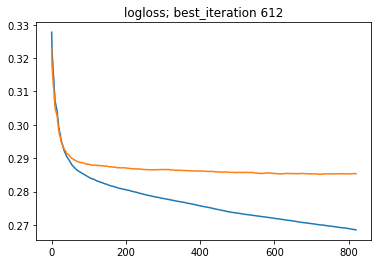

In [22]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

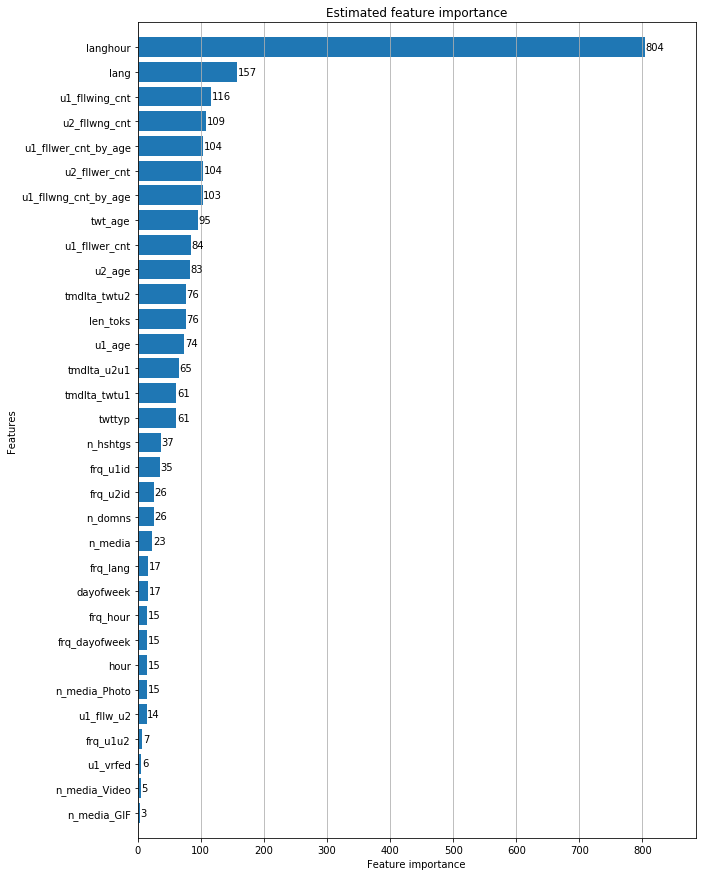

In [23]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [24]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
26,langhour,804
1,lang,157
3,u1_fllwing_cnt,116
6,u2_fllwng_cnt,109
24,u1_fllwer_cnt_by_age,104
5,u2_fllwer_cnt,104
25,u1_fllwng_cnt_by_age,103
21,twt_age,95
2,u1_fllwer_cnt,84
23,u2_age,83


# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 12 s, sys: 5.42 s, total: 17.4 s
Wall time: 1.44 s


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 840 ms, sys: 1.21 s, total: 2.05 s
Wall time: 680 ms


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3738
auc_vl:  0.2778
auc_val: 0.0873

rce_tr:  19.0839
rce_vl:  13.5636
rce_val: 9.6936


# save results

In [28]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [29]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [30]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 36.5 ms, sys: 210 ms, total: 247 ms
Wall time: 16.7 ms


In [31]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-06 02:40:58 start
2020-04-06 02:40:59 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 02:40:59 freq of tags
2020-04-06 02:40:59 done
CPU times: user 236 ms, sys: 938 ms, total: 1.17 s
Wall time: 154 ms


In [32]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [33]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 18.7 ms, sys: 8.21 ms, total: 26.9 ms
Wall time: 19.9 ms


In [34]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)